# Importing Libraries

In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reading Files

In [3]:
path1 = "/kaggle/input/glaucomadgs/Image/Images/*"
path2 = "/kaggle/input/glaucomadgs/OD/OD/*"
path3 = "/kaggle/input/glaucomadgs/OC/OC/*"

In [25]:
path1 = "/kaggle/input/augglaucomags/aug/img/*"
path2 = "/kaggle/input/augglaucomags/aug/OD/*"
path3 = "/kaggle/input/augglaucomags/aug/OC/*"

# Enabling GPU

In [26]:
tf.test.is_gpu_available()

True

In [27]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [28]:
train_files = glob(path1)
od_files = glob(path2)
oc_files = glob(path3)

train_files.sort()
od_files.sort()
oc_files.sort()

print(len(train_files))
print(len(od_files))
print(len(oc_files))

707
707
707


In [9]:
os.makedirs('/kaggle/working/aug/img')

In [18]:
# import required library
import cv2
# from google.colab.patches import cv2_imshow
import numpy as np
from skimage.util import random_noise
from skimage import io
c = 607
l = len(train_files)
filename_img = "/kaggle/working/aug/img/"
filename_oc = "/kaggle/working/aug/OC/"
filename_od = "/kaggle/working/aug/OD/"
for i in range(l):
  # read input image
  img = cv2.imread(train_files[i])
  od = cv2.imread(od_files[i])
  oc = cv2.imread(oc_files[i])
  
#   img = cv2.resize(img, (256, 256),interpolation = cv2.INTER_AREA)
#   od = cv2.resize(od, (256, 256),interpolation = cv2.INTER_AREA)
#   oc = cv2.resize(oc, (256, 256),interpolation = cv2.INTER_AREA)

#   img1 = cv2.flip(img, -1)
#   od1 = cv2.flip(od,-1)
#   oc1 = cv2.flip(oc,-1)

  img1 =  cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  od1 =  cv2.rotate(od,cv2.ROTATE_90_COUNTERCLOCKWISE)
  oc1 =  cv2.rotate(oc, cv2.ROTATE_90_COUNTERCLOCKWISE)
#   noisy_img = random_noise(img1, mode='gaussian', var=0.1**2)
  cv2.imwrite(filename_img+str(c)+".png",img1) 
  cv2.imwrite(filename_od+str(c)+".png", od1) 
  cv2.imwrite(filename_oc+str(c)+".png", oc1) 
  c+=1
  # display the rotated image
  # cv2_imshow(img_v)

(256, 256, 3)


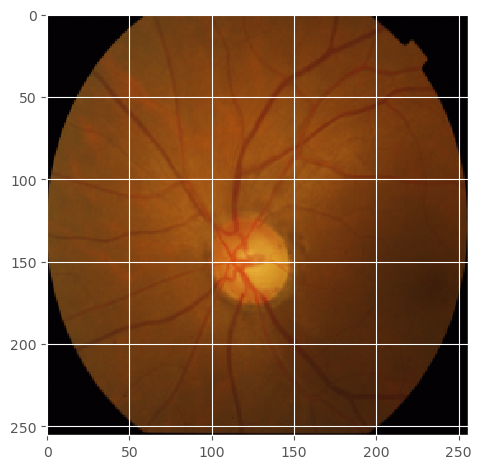

In [50]:
a = io.imread(train_files[84])
# b =  cv2.rotate(a, cv2.ROTATE_90_CLOCKWISE)
print(a.shape)
io.imshow(a)

In [19]:
# from glob import glob 
train_files = glob("/kaggle/working/aug/img/*")
od_files = glob("/kaggle/working/aug/OD/*")
oc_files = glob("/kaggle/working/aug/OC/*")

train_files.sort()
od_files.sort()
oc_files.sort()

print(len(train_files))
print(len(od_files))
print(len(oc_files))

707
707
707


# Unet Model

In [17]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model



In [43]:
 input_shape = (256, 256, 3)
model = build_unet(input_shape)

# Calculating metrics

In [45]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Training the Model

In [46]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
# from model import build_unet
# from metrics import dice_loss, dice_coef, iou

""" Global parameters """
H = 256
W = 256

def create_dir(path):
    """ Create a directory. """
    if not os.path.exists(path):
        os.makedirs(path)

def load_data(path, split=0.1):
    images = sorted(glob(os.path.join("/kaggle/working/aug/img/", "*.png")))
    print(len(images))
    masks1 = sorted(glob(os.path.join("/kaggle/working/aug/OD/",  "*.png")))
#     masks2 = sorted(glob(os.path.join(path, "ManualMask", "rightMask", "*.png")))
    print(len(images))
    # print(os.path.join(path, "Image","Images" "*.png"))

    split_size = 0.1
    split_size2= 0.2

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y1, valid_y1 = train_test_split(masks1, test_size=split_size, random_state=42)
#     train_y2, valid_y2 = train_test_split(masks2, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y1, test_y1 = train_test_split(train_y1, test_size=split_size, random_state=42)
#     train_y2, test_y2 = train_test_split(train_y2, test_size=split_size, random_state=42)

    return (train_x, train_y1), (valid_x, valid_y1), (test_x, test_y1)

def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x

def read_mask(path1):
    x1 = cv2.imread(path1, cv2.IMREAD_GRAYSCALE)
#     x2 = cv2.imread(path2, cv2.IMREAD_GRAYSCALE)
    x = x1 
    x = cv2.resize(x, (W, H))
    x = x/np.max(x)
    x = x > 0.5
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=-1)
    return x

def tf_parse(x, y1):
    def _parse(x, y1):
        x = x.decode()
        y1 = y1.decode()
#         y2 = y2.decode()

        x = read_image(x)
        y = read_mask(y1)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y1], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y1, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y1))
    dataset = dataset.shuffle(buffer_size=200)
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(4)
    return dataset

In [ ]:
""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
os.makedirs("/kaggle/working/files1/")

""" Hyperparameters """
batch_size = 2
lr = 1e-5
num_epochs = 2
model_path = os.path.join("/kaggle/working/", "unet-double.h5")
csv_path = os.path.join("/kaggle/working/", "data.csv")

""" Dataset """
dataset_path = "/kaggle/working/aug"
(train_x, train_y1), (valid_x, valid_y1), (test_x, test_y1) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y1)} ")
print(f"Valid: {len(valid_x)} - {len(valid_y1)}")
print(f"Test: {len(test_x)} - {len(test_y1)}")

train_dataset = tf_dataset(train_x, train_y1, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y1, batch=batch_size)

""" Model """
model = build_unet((H, W, 3))
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
    CSVLogger(csv_path)
]

history = model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks
    )

# Predicting 

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.utils import CustomObjectScope
# from metrics import dice_loss, dice_coef, iou
# from train import load_data, create_dir, tf_dataset

H = 256
W = 256


""" Seeding """
np.random.seed(42)
tf.random.set_seed(42)

""" Directory for storing files """
create_dir("results")

#     """ Loading model """
#     with CustomObjectScope({'iou': iou, 'dice_coef': dice_coef, 'dice_loss': dice_loss}):
#         model = tf.keras.models.load_model("/kaggle/working/model.h5")

""" Dataset """
dataset_path = "/kaggle/working/aug/"
(train_x, train_y1), (valid_x, valid_y1), (test_x, test_y1) = load_data(dataset_path)

""" Predicting the mask """
for x, y1 in tqdm(zip(test_x, test_y1), total=len(test_x)):
        print(x)
        print(y1)
        image_name = x.split("/")[-1]

        """ Reading the image """
        ori_x = cv2.imread(x, cv2.IMREAD_COLOR)
        ori_x = cv2.resize(ori_x, (W, H))
        x = ori_x/255.0
        x = x.astype(np.float32)
        x = np.expand_dims(x, axis=0)

        """ Reading the mask """
        ori_y1 = cv2.imread(y1, cv2.IMREAD_GRAYSCALE)
#         ori_y2 = cv2.imread(y2, cv2.IMREAD_GRAYSCALE)
        ori_y = ori_y1 
        ori_y = cv2.resize(ori_y, (W, H))
        ori_y = np.expand_dims(ori_y, axis=-1)  ## (512, 512, 1)
        ori_y = np.concatenate([ori_y, ori_y, ori_y], axis=-1)  ## (512, 512, 3)

        """ Predicting the mask. """
        y_pred = model.predict(x)[0] > 0.5
        y_pred = y_pred.astype(np.int32)

        """ Saving the predicted mask along with the image and GT """
        save_image_path = "/kaggle/working/result55/"+image_name
#         save_image_path2 = "/kaggle/working/result2/"+image_name
        print(image_name)
        y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1)

        sep_line = np.ones((H, 10, 3)) * 255

        cat_image = np.concatenate([ori_x, sep_line, ori_y, sep_line, y_pred*255], axis=1)
        cv2.imwrite(save_image_path, cat_image)
#         cv2.imwrite(save_image_path2, ori_y)
        

# Displaying outputs

In [165]:

import os
a = os.listdir("/kaggle/working/result55/")
print(len(a))


37


In [83]:
a[36]

'65.png'

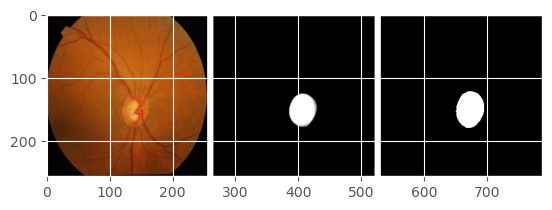

In [167]:
from PIL import Image
a1 = Image.open("/kaggle/working/result55/"+a[17])
plt.imshow(a1)
plt.show()

In [16]:
os.rmdir("/kaggle/working/files1/")

In [143]:
from IPython.display import FileLink

FileLink(r'modelunet3+.h5')

/kaggle/working/modelunet3+.h5

# Plotting

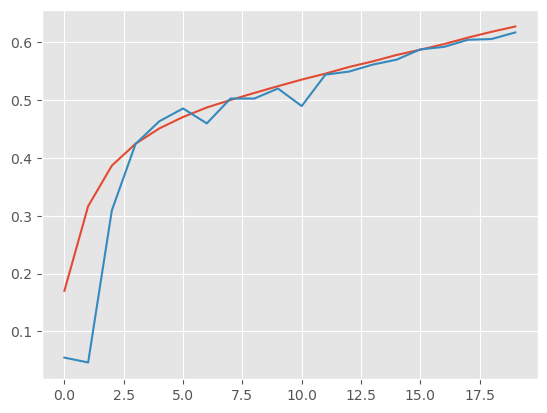

In [162]:
plt.plot(history.history["dice_coef"])
plt.plot(history.history["val_dice_coef"])

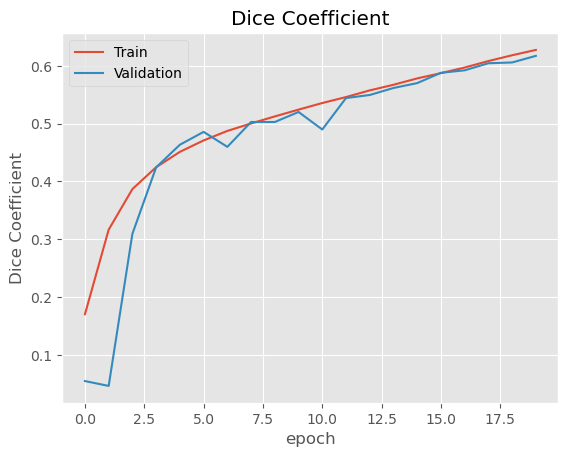

In [163]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Dice Coefficient')
plt.ylabel('Dice Coefficient')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['Train', 'Validation'], loc='upper left')
# plt.show()

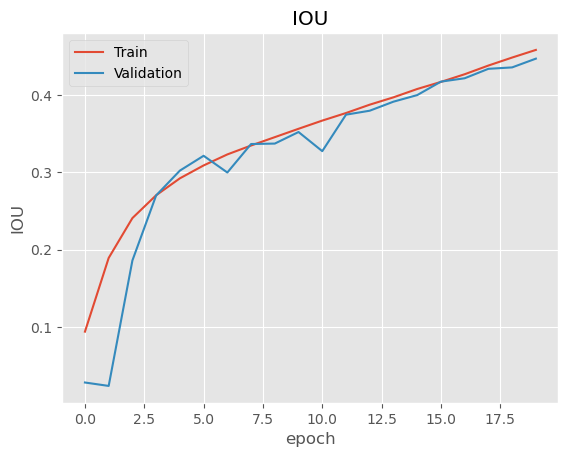

In [164]:
plt.plot(history.history['iou'])
plt.plot(history.history['val_iou'])
plt.title('IOU')
plt.ylabel('IOU')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [77]:
s = y_pred*255
cv2.imwrite("/kaggle/working/s.png",s)

True

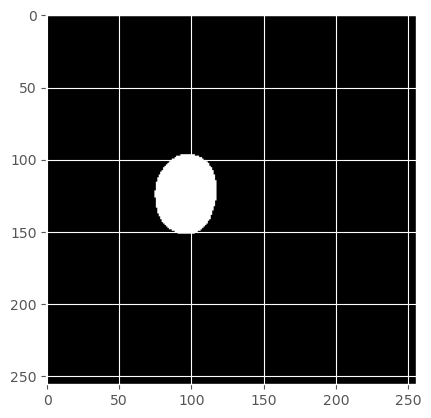

In [84]:
a1 = Image.open("/kaggle/working/s.png")
plt.imshow(a1)
plt.show()

In [73]:
cv2.imwrite("/kaggle/working/o.png",ori_y)

True

In [130]:

a1 = cv2.imread("/kaggle/working/result1/"+d[0])
a2 = cv2.imread("/kaggle/working/result1/"+o[0])
# counting the number of pixels
n1 = np.sum(a1 == 255)
n2 = np.sum(a2 == 255)
print(n1)
print(n2)
# number_of_black_pix = np.sum(img == 0)

3636
3636


In [139]:

a1 = cv2.imread(od_files[6])
a2 = cv2.imread(oc_files[6])
# counting the number of pixels
n1 = np.sum(a1 == 255)
n2 = np.sum(a2 == 255)
print(n1)
print(n2)
print(n2/n1)

4152
300
0.07225433526011561


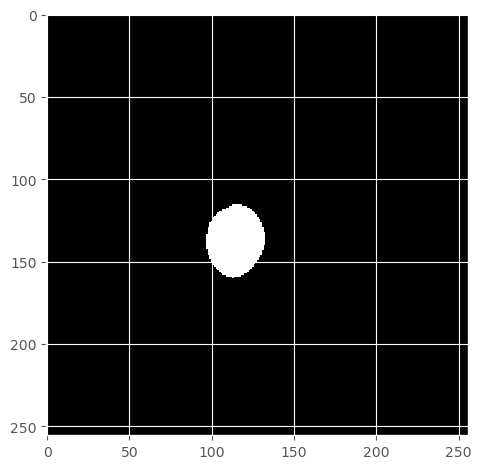

In [129]:
io.imshow(a2)

In [104]:
import cv2
import numpy as np

img = cv2.imread("/kaggle/working/s.png", cv2.IMREAD_GRAYSCALE)
i = cv2.imread("/kaggle/working/o.png", cv2.IMREAD_GRAYSCALE)
n_white_pix = np.sum(img == 255)
n = np.sum(i == 255)
print('Number of white pixels:', n_white_pix)
print('Number of white pixels:', n)

Number of white pixels: 1887
Number of white pixels: 499


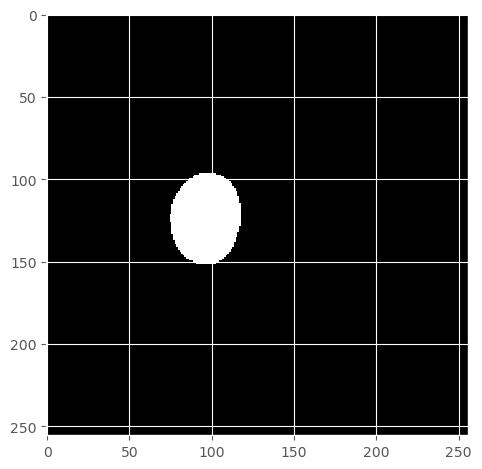

In [105]:
io.imshow(img)

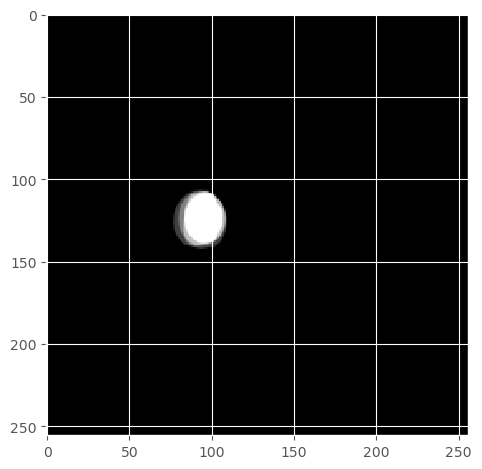

In [106]:
io.imshow(i)